In [37]:
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


In [38]:
x_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv",header=None)

x_test = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv",header=None)

In [39]:

# Convert to numpy arrays and adjust labels
x_train = x_train.to_numpy().reshape(-1, 32, 32, 1) / 255.0
y_train = y_train.to_numpy().flatten() - 1
x_test = x_test.to_numpy().reshape(-1, 32, 32, 1) / 255.0
y_test = y_test.to_numpy().flatten() - 1


# Shuffle the datasets
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

# One-hot encode the labels
y_train_h = to_categorical(y_train, num_classes=28)
y_test_h = to_categorical(y_test, num_classes=28)

# Split the training data into training and validation sets
x_train, x_val, y_train_h, y_val_h = train_test_split(x_train, y_train_h, test_size=0.2, random_state=42)

# Data augmentation for training data generator
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# Prepare data generators
train_generator = train_datagen.flow(x_train, y_train_h, batch_size=64)
val_generator = train_datagen.flow(x_val, y_val_h, batch_size=64)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test_h, batch_size=64)

# Model architecture
model = Sequential([
    Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=(32, 32, 1)),
    Conv2D(32, (5, 5), activation="relu"),
    Conv2D(32, (5, 5), activation="relu"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (5, 5), padding="same", activation="relu"),
    Conv2D(64, (5, 5), activation="relu"),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dense(28, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




In [40]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []  # List to store accuracy

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_acc.append(acc)  # Append accuracy to the list
        print(f'\nTesting loss: {loss}, acc: {acc}')


In [41]:
# Train the model
test_callback = TestCallback((x_test, y_test_h))
history = model.fit(
    train_generator, 
    epochs=100,  
    validation_data=val_generator,
    callbacks=[test_callback]  
)

Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 3.1276 - accuracy: 0.1177
Testing loss: 3.440788984298706, acc: 0.0357142873108387
168/168 [==============================] - 9s 30ms/step - loss: 3.1276 - accuracy: 0.1177 - val_loss: 3.4521 - val_accuracy: 0.0376
Epoch 2/100
166/168 [============================>.] - ETA: 0s - loss: 2.2695 - accuracy: 0.2925
Testing loss: 5.517096996307373, acc: 0.0357142873108387
168/168 [==============================] - 5s 29ms/step - loss: 2.2658 - accuracy: 0.2934 - val_loss: 5.6105 - val_accuracy: 0.0387
Epoch 3/100
168/168 [==============================] - ETA: 0s - loss: 1.6547 - accuracy: 0.4359
Testing loss: 4.2898173332214355, acc: 0.06428571790456772
168/168 [==============================] - 5s 28ms/step - loss: 1.6547 - accuracy: 0.4359 - val_loss: 4.8482 - val_accuracy: 0.0580
Epoch 4/100
166/168 [============================>.] - ETA: 0s - loss: 1.2841 - accuracy: 0.5660
Testing loss: 1.6428041458129883, acc: 0.46

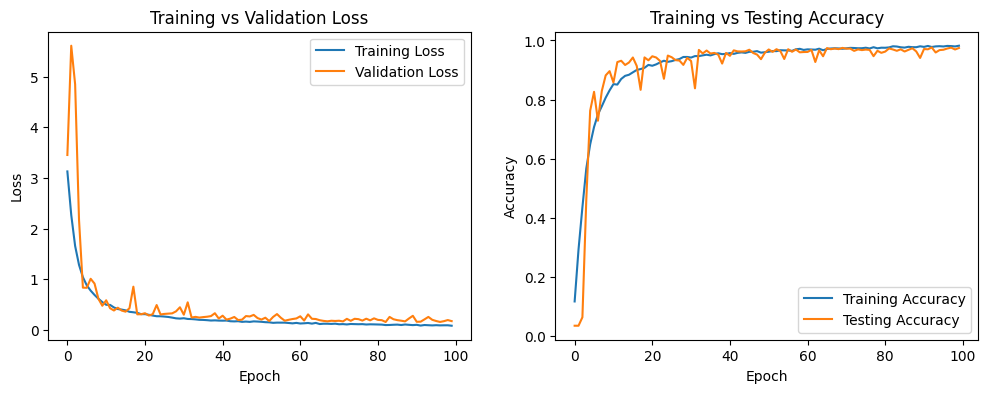

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(test_callback.test_acc, label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

105/105 [==============================] - 0s 2ms/step


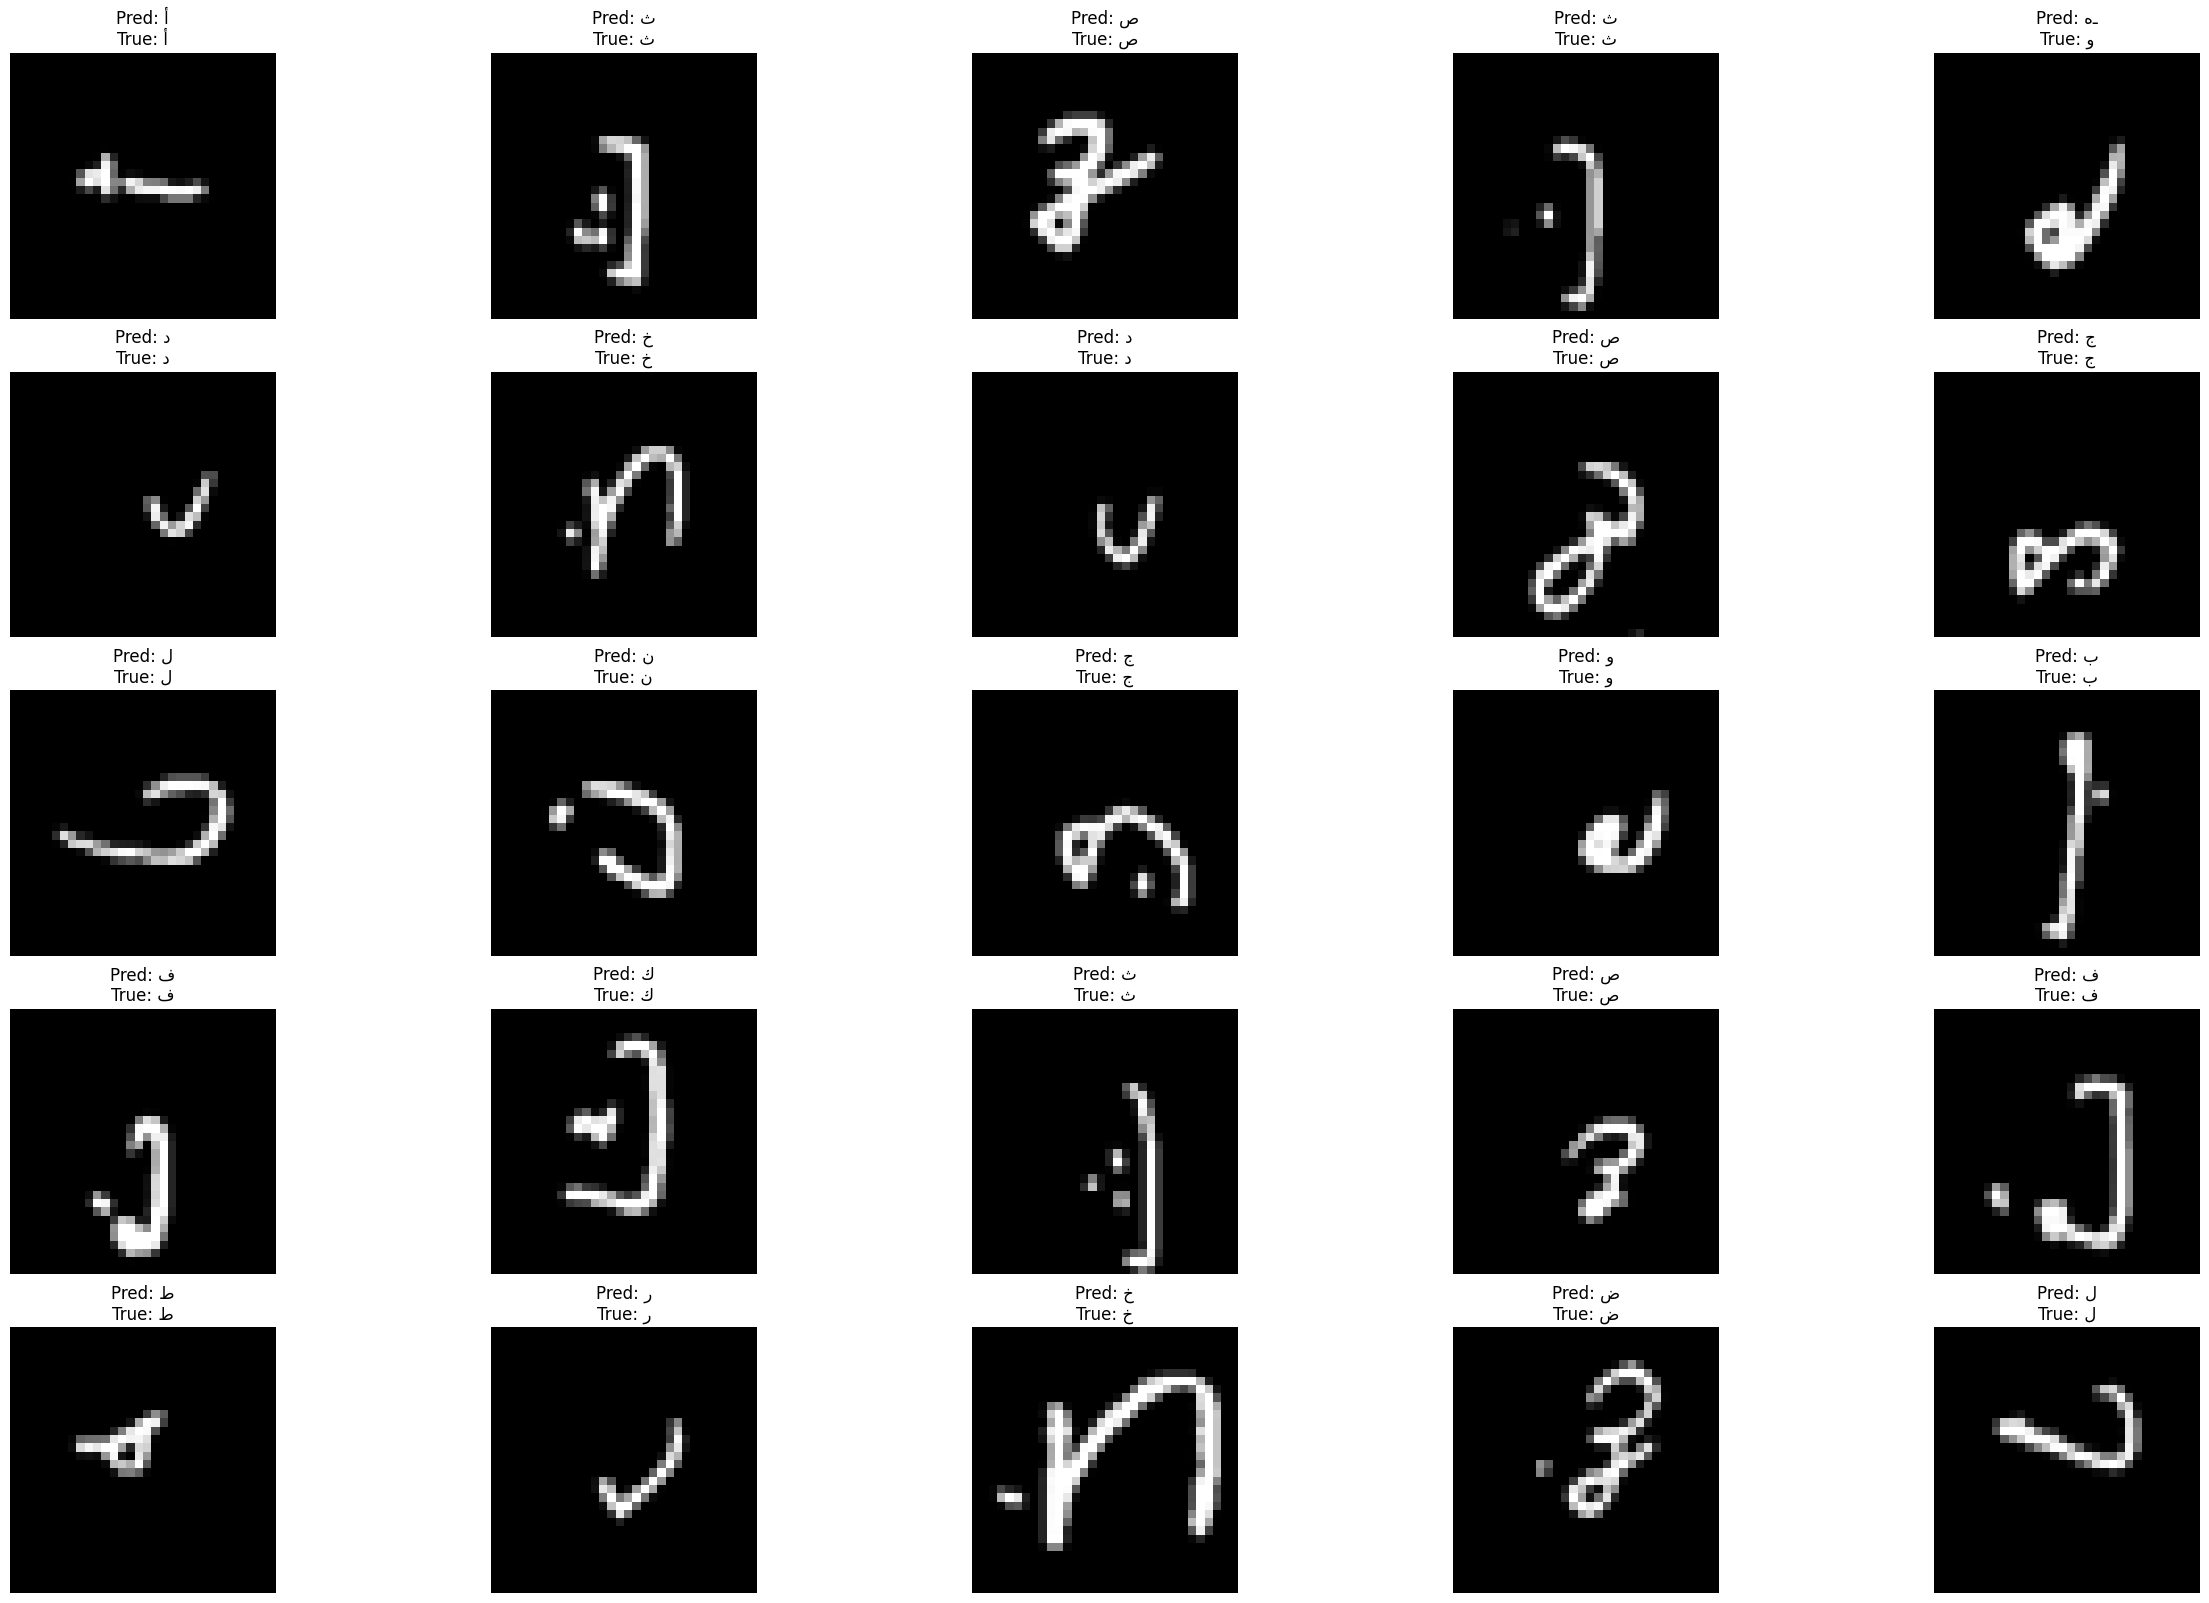

In [43]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming you have created a label_mapping earlier
arabic_chars = {
    0: 'أ', 1: 'ب', 2: 'ت', 3: 'ث', 4: 'ج', 5: 'ح', 6: 'خ', 7: 'د', 8: 'ذ',
    9: 'ر', 10: 'ز', 11: 'س', 12: 'ش', 13: 'ص', 14: 'ض', 15: 'ط', 16: 'ظ',
    17: 'ع', 18: 'غ', 19: 'ف', 20: 'ق', 21: 'ك', 22: 'ل', 23: 'م', 24: 'ن',
    25: 'هـ', 26: 'و', 27: 'ي'
}

# Display 25 images along with their predicted and true labels
plt.figure(figsize=(30, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(32, 32), cmap='gray')
    plt.title(f'Pred: {arabic_chars[predicted_labels[i]]}\nTrue: {arabic_chars[y_test[i]]}')
    plt.axis('off')

plt.show()

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(y_test.flatten(), predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print precision, recall, and confusion matrix
precision = precision_score(y_test.flatten(), predicted_labels, average='macro')
recall = recall_score(y_test.flatten(), predicted_labels, average='macro')
conf_matrix = confusion_matrix(y_test.flatten(), predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.9744
Precision: 0.9749
Recall: 0.9744
